In [480]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
  
from sklearn import neighbors
    
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

from sklearn.ensemble import RandomForestClassifier

# 1 Data Import & Clean

In [481]:
df = pd.read_csv('titanic.csv')

In [482]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [483]:
#check missing data
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [484]:
#check y value
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### 1-1 Age

In [485]:
#(1)fill missing data
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Age'].isna().sum()

0

In [486]:
df['Age'].describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [487]:
#(2)categorize Age     #std around 13
df.loc[(df['Age'] <= 13), 'Age'] = 0
df.loc[(df['Age'] > 13) & (df['Age'] <= 26), 'Age'] = 1
df.loc[(df['Age'] > 26) & (df['Age'] <= 39), 'Age'] = 2
df.loc[(df['Age'] > 39) & (df['Age'] <= 52), 'Age'] = 3
df.loc[(df['Age'] > 26) & (df['Age'] <= 39), 'Age'] = 4
df.loc[(df['Age'] > 39), 'Age'] = 5

In [488]:
df['Age'].value_counts()

2.0    409
1.0    248
3.0    112
0.0     71
5.0     51
Name: Age, dtype: int64

### 1-2 Embarked

In [489]:
#(1)fill missing data
df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [490]:
#fill with top frequency data
df['Embarked'] = df['Embarked'].fillna('S')
df['Embarked'].isna().sum()

0

In [491]:
#(2)categorize Embarked
df['Embarked'] = df['Embarked'].map( {"S": 0, "C": 1, "Q": 2})
print (df['Embarked'].value_counts())

0    646
1    168
2     77
Name: Embarked, dtype: int64


### 1-3 Fare

In [492]:
#(1)fill missing data with median
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Fare'].isna().sum()

0

In [493]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [494]:
#catgorize Fare
#since Q3 still < std, we choose quartile instead 
df.loc[(df['Fare'] <= 7.9), 'Fare'] = 0
df.loc[(df['Fare'] > 7.9)  & (df['Fare'] <= 14.4), 'Fare'] = 1
df.loc[(df['Fare'] > 14.4) & (df['Fare'] <= 31), 'Fare'] = 2
df.loc[(df['Fare'] > 31), 'Fare'] = 3

In [495]:
df['Fare'].value_counts()

2.0    229
0.0    223
3.0    222
1.0    217
Name: Fare, dtype: int64

### 1-4 SibSp + Parch

In [496]:
#we can interpret SibSp + Parch = how many family members on-board
df['FamilyOnBoard'] = df['SibSp'] + df['Parch']
df['FamilyOnBoard'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilyOnBoard, dtype: int64

### 1-5 Sex

In [497]:
df['Sex_Female'] = df['Sex'].map( {'female': 1, 'male': 0}).astype(int)
df['Sex_Female'].head(5)

0    0
1    1
2    1
3    1
4    0
Name: Sex_Female, dtype: int64

### 1-6 Del clolumns & Review

In [498]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyOnBoard,Sex_Female
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0.0,NaN,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,3.0,C85,1,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,1.0,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,3.0,C123,0,1,1
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,1.0,NaN,0,0,0


In [499]:
#drop PassengerId, Ticket because we couldn't extract information from these two columns
#drop Cabin since too much missing data (over 77%)
#drop Name since even we extract titles from it, the information already be covered by Sex and Age columns
#drop Sex, SibSp, and Parch since we already extract information and transfer to other columns

dropColumns = ['PassengerId', 'Ticket', 'Cabin', 'Name', 'Sex', 'SibSp', 'Parch']
df = df.drop(dropColumns, axis =1)

In [500]:
df.head()

,Survived,Pclass,Age,Fare,Embarked,FamilyOnBoard,Sex_Female
0,0,3,1.0,0.0,0,1,0
1,1,1,2.0,3.0,1,1,1
2,1,3,1.0,1.0,0,0,1
3,1,1,2.0,3.0,0,1,1
4,0,3,2.0,1.0,0,0,0


# 2 Modeling & Predicting

## 2-1 Logistic Regression

In [501]:
df_LR = df.copy() #copy original df
df_LR.head(2)

,Survived,Pclass,Age,Fare,Embarked,FamilyOnBoard,Sex_Female
0,0,3,1.0,0.0,0,1,0
1,1,1,2.0,3.0,1,1,1


In [502]:
#assign X & y
X = df_LR[['Pclass', 'Age','Fare', 'Embarked', 'FamilyOnBoard', 'Sex_Female']]
y = df_LR['Survived']

In [503]:
#split train 80% & test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [504]:
print (len(X_train), len(y_train))
print (len(X_test), len(y_test))

712 712
179 179


In [505]:
#apply LogisticRegression model
logreg = LogisticRegression(solver= 'liblinear', max_iter= 1000)
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [506]:
#get the TRAIN set accuracy score
y_hat = logreg.predict(X_train)
Cmatrix = confusion_matrix(y_train, y_hat)
print(Cmatrix)

[[383  56]
 [ 83 190]]


In [507]:
FN = Cmatrix[1,0]
TP = Cmatrix[0,0]
FP = Cmatrix[0,1]
TN = Cmatrix[1,1]

Acc = float(TP + TN)/(FP + FN + TP + TN)
Err = float(FP + FN)/(FP + FN + TP + TN) 

FNR = float(FN)/(FN + TP)
TPR = float(TP)/(FN + TP) 
FPR = float(FP)/(FP + TN)
TNR = float(TN)/(FP + TN)
print ('FNR:%r, TPR:%r, FPR:%r, TNR:%r' %(FNR, TPR, FPR, TNR))
print ('Accuracy score:%r, Misclassification Error = %r' %(Acc, Err) )

FNR:0.1781115879828326, TPR:0.8218884120171673, FPR:0.22764227642276422, TNR:0.7723577235772358
Accuracy score:0.8047752808988764, Misclassification Error = 0.1952247191011236


### Interpret Coefficient

In [508]:
print ('intercept:', logreg.intercept_)

intercept: [0.963]


In [509]:
print('coefficient')
list(zip( X_train.columns.values, logreg.coef_[0,:]))

coefficient


[('Pclass', -0.8206902205711927),
 ('Age', -0.43487418561697033),
 ('Fare', 0.23905032677717653),
 ('Embarked', 0.299283205921649),
 ('FamilyOnBoard', -0.27601507151388616),
 ('Sex_Female', 2.5685668442401353)]

#### We could interpret 1 unit increase in 'Sex_Female' is associated with 2.7 unit increase in the log-odds of 'Survived'.
#### Also, we could transfer such information to formula:
#### log-odds = 0.96 - (0.82 * Pclass) - (0.43 * Age) + (0.24 * Fare) + (0.30 * Embarked) - (0.28 * FamilyOnBoard) + (2.6 * Sex_Female)
#### Obviously, Sex_Frmale strongly affects our model

### Predict Performance

In [510]:
#apply logreg to TEST set
y_hat = logreg.predict(X_test)
Cmatrix = confusion_matrix(y_test, y_hat)
print(Cmatrix)

[[93 17]
 [18 51]]


In [511]:
#utilize confusion matrix to get precdiction accuracy score
FN = Cmatrix[1,0]
TP = Cmatrix[0,0]
FP = Cmatrix[0,1]
TN = Cmatrix[1,1]

Acc = float(TP + TN)/(FP + FN + TP + TN)
Err = float(FP + FN)/(FP + FN + TP + TN) 

print ('Accuracy score:%r, Misclassification Error = %r' %(Acc, Err) )

Accuracy score:0.8044692737430168, Misclassification Error = 0.19553072625698323


In [512]:
#double check the score
ScoreLR = logreg.score(X_test, y_test)
print('The prediction accuracy score:', ScoreLR)

The prediction accuracy score: 0.8044692737430168


#### The test accuracy score is slightly lower than train set around 80%, which means the model with good accuracy.

## 2-2 KNN

In [513]:
df_KNN = df.copy() #copy original df
df_KNN.head(2)

,Survived,Pclass,Age,Fare,Embarked,FamilyOnBoard,Sex_Female
0,0,3,1.0,0.0,0,1,0
1,1,1,2.0,3.0,1,1,1


In [514]:
#assign X & y
X = df_KNN[['Pclass', 'Age','Fare', 'Embarked', 'FamilyOnBoard', 'Sex_Female']]
y = df_KNN['Survived']

In [515]:
#split train 80% & test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [516]:
#apply KNeighborClassifier model
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance') #default pick k = 5
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

In [517]:
#check score
y_hat = knn.predict(X_train)
print('Accuracy Score:', metrics.accuracy_score(y_train, y_hat))

Accuracy Score: 0.8834269662921348


### Find the optimal k-folds

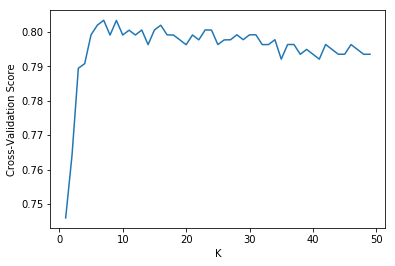

Best CV score and K: (0.8033769282360833, 7)


In [518]:
#cross-validation by accuracy
CV_Scores = []
k_Range = range(1,50)

for k in k_Range:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, weights= 'distance')
    CV_Scores.append(cross_val_score(knn, X_train, y_train, cv=10, scoring = 'accuracy').mean())    

plt.plot(k_Range, CV_Scores)
plt.xlabel("K")
plt.ylabel("Cross-Validation Score")
plt.show()
print ('Best CV score and K:',max(list(zip(CV_Scores, k_Range))))

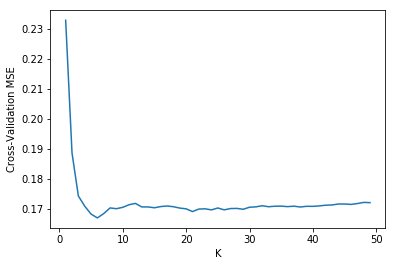

Best MSE score and K: (0.1669847941672108, 6)


In [519]:
#cross-validation by MSE
CV_Scores = []
k_Range = range(1,50)

for k in k_Range:
    knn = neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    CV_Scores.append( -cross_val_score(knn, X_train, y_train, cv=10,
                                    scoring = 'neg_mean_squared_error').mean())    


plt.plot(k_Range, CV_Scores)
plt.xlabel("K")
plt.ylabel("Cross-Validation MSE")
plt.show()
print ('Best MSE score and K:',min(list(zip(CV_Scores, k_Range))))

### Predict Performance

In [520]:
#according to our exam, we apply k = 6 or 7 to TEST set
k_list = [7, 6]
for i in k_list:
    knn = neighbors.KNeighborsClassifier(n_neighbors=i, weights='distance') 
    knn.fit(X_train,y_train)
    y_hat = knn.predict(X_test)
    print('When k = %d Scored:'%(i), metrics.accuracy_score(y_test, y_hat))
    knn.score(X_test, y_test)

When k = 7 Scored: 0.8100558659217877
When k = 6 Scored: 0.8212290502793296


In [521]:
#pick k = 6
ScoreKNN = knn.score(X_test, y_test)
print ('The prediction accuracy score:', ScoreKNN)

The prediction accuracy score: 0.8212290502793296


#### The classification rate is over 82%, which means good accuracy. 
#### And set weights = 'distance' get better prediction model than weights = 'uniform'

## 2-3 Decision Tree Classifier

In [553]:
df_DT = df.copy() #copy original df
df_DT.head(2)

,Survived,Pclass,Age,Fare,Embarked,FamilyOnBoard,Sex_Female
0,0,3,1.0,0.0,0,1,0
1,1,1,2.0,3.0,1,1,1


In [554]:
#assign X & y
X = df_DT[['Pclass', 'Age','Fare', 'Embarked', 'FamilyOnBoard', 'Sex_Female']]
y = df_DT['Survived']

In [555]:
#split train 80% & test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Find the optimal Nodes & Depth

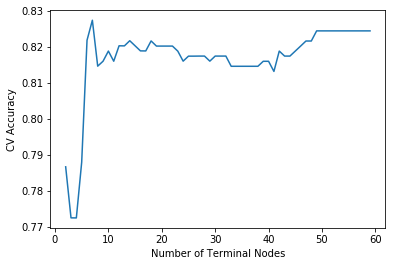

In [556]:
Maximum_Terminal_Nodes = range(2,60)
score = []
for i in Maximum_Terminal_Nodes:
    TreeClass = DecisionTreeClassifier(max_leaf_nodes = i, min_samples_leaf = 5, random_state = 1000)
    score.append((cross_val_score(TreeClass, X_train, y_train, cv=10, scoring = 'accuracy')).mean())

plt.plot(Maximum_Terminal_Nodes, score)
plt.xlabel("Number of Terminal Nodes")
plt.ylabel("CV Accuracy")
plt.show()

In [557]:
CV_MSE_Max = np.argmax(score)
Maximum_Terminal_Node = Maximum_Terminal_Nodes[CV_MSE_Max]
print("The best maximum terminal node is %r, and the accuracy = %r" %(Maximum_Terminal_Node, np.max(score)))

The best maximum terminal node is 7, and the accuracy = 0.8273418287502794


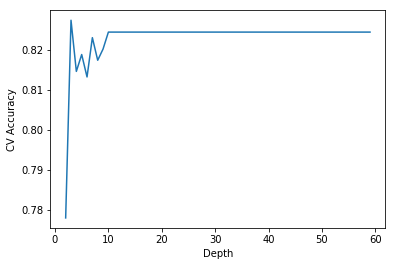

In [558]:
Maximum_Depth = range(2,60)
score = []
for i in Maximum_Depth:
    TreeClass = DecisionTreeClassifier(max_depth = i, min_samples_leaf = 5, random_state = 1000)
    score.append((cross_val_score(TreeClass, X_train, y_train, cv=10, scoring = 'accuracy')).mean())

plt.plot(Maximum_Depth, score)
plt.xlabel("Depth")
plt.ylabel("CV Accuracy")
plt.show()

In [559]:
CV_MSE_Max = np.argmax(score)
Maximum_Depth = Maximum_Depth[CV_MSE_Max]
print("The best maximum depth is %r, and the accuracy = %r" %(Maximum_Depth, np.max(score)))

The best maximum depth is 3, and the accuracy = 0.8273418287502794


### Predict Performance

In [560]:
#apply optimal nodes & depth above to TEST set
TreeClass = DecisionTreeClassifier( min_samples_leaf = 7, max_depth = 3, random_state = 24)
TreeClass.fit(X_train, y_train)
TreeClass.score(X_train, y_train)

0.8314606741573034

In [561]:
#double check score
ScoreDT = TreeClass.score(X_test, y_test)
y_hat = TreeClass.predict(X_test)

print ('The prediction accuracy score:', ScoreDT)
print('The prediction accuracy score:', metrics.accuracy_score(y_test, y_hat))

The prediction accuracy score: 0.8324022346368715
The prediction accuracy score: 0.8324022346368715


In [562]:
importancesDf = pd.DataFrame({'feature':X_test.columns.values, 'importance':TreeClass.feature_importances_})
importancesDf.sort_values(by = ['importance'], ascending = False).set_index('feature')
importancesDf.head(6)

,feature,importance
0,Pclass,0.178791
1,Age,0.060347
2,Fare,0.002551
3,Embarked,0.000000
4,FamilyOnBoard,0.128050
5,Sex_Female,0.630261


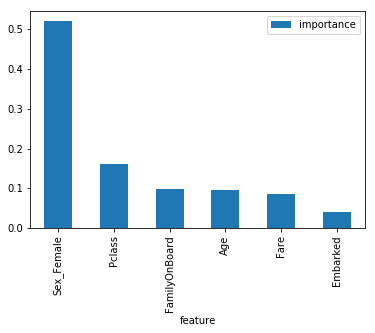

In [563]:
importances.plot.bar()

#### The classification rate is over 83% in test set and close to the train set, which means the prediction model with good accuracy.

Train data score after optimization 0.8314606741573034


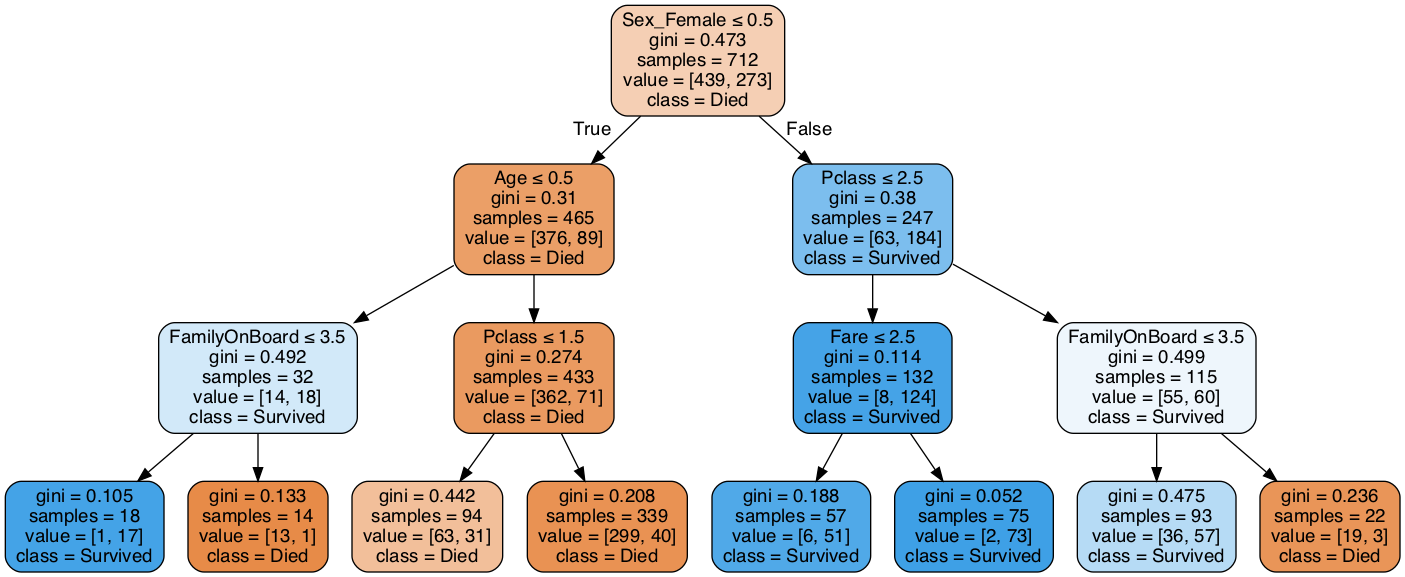

In [564]:
#tree visulization with TRAIN set
print ('Train data score after optimization', TreeClass.score(X_train, y_train))

dot_data = StringIO()
feature_cols = X_train.columns
export_graphviz(TreeClass, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns.values,
                class_names=['Died', 'Survived'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Titanic_tree.png')
Image(graph.create_png())

## 2-4 Random Forest  Classification

In [565]:
df_RFC = df.copy() #copy original df
df_RFC.head(2)

,Survived,Pclass,Age,Fare,Embarked,FamilyOnBoard,Sex_Female
0,0,3,1.0,0.0,0,1,0
1,1,1,2.0,3.0,1,1,1


In [566]:
#assign X & y
X = df_RFC[['Pclass', 'Age','Fare', 'Embarked', 'FamilyOnBoard', 'Sex_Female']]
y = df_RFC['Survived']

In [567]:
#split train 80% & test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [568]:
#apply model to TRAIN sets
RFClass = RandomForestClassifier(n_estimators = 2000, max_features = 6, min_samples_leaf = 5, 
                                 oob_score = True, random_state = 1, n_jobs = -1) 
#build 2000 trees with all features
RFClass.fit(X_train, y_train)

scores = cross_val_score(RFClass, X_train, y_train, cv = 10)

print("Out of Bag Accuracy  = %f" %RFClass.oob_score_)
print("CV Accuracy = %f" %scores.mean())

Out of Bag Accuracy  = 0.813202
CV Accuracy = 0.824445


### Optimal feature selection

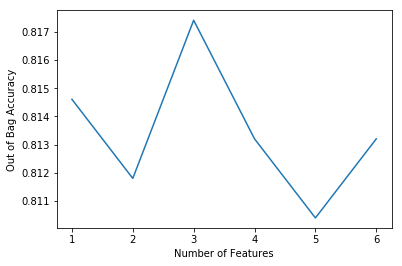

The Out of Bag Accuracy = 0.8174157303370787 and Number of Features = 3


In [569]:
#scan through each feature to find the best combination
Features = range(1,7)
oob_score_RF = []
for i in Features:
        RFClass = RandomForestClassifier(n_estimators = 2000, max_features = i, min_samples_leaf = 5,
                                         oob_score = True, random_state = 1, n_jobs = -1)
        
        RFClass.fit(X_train, y_train)  
        oob_score_RF.append(RFClass.oob_score_)

plt.plot(Features, oob_score_RF)
plt.xlabel("Number of Features")
plt.ylabel("Out of Bag Accuracy")
plt.show()             

print ('The Out of Bag Accuracy = %r and Number of Features = %r' %max(list(zip(oob_score_RF, Features)))) 

### Predict Performance

In [570]:
#apply our optimal feature to the model
RFClass = RandomForestClassifier(n_estimators = 2000, max_features = 3, min_samples_leaf = 5, 
                                 oob_score = True, random_state = 1, n_jobs = -1)
RFClass.fit(X_train, y_train)

scores = cross_val_score(RFClass, X_train, y_train, cv = 10)

print("Out of Bag Accuracy  = %f" %RFClass.oob_score_)
print("CV Accuracy = %f" %scores.mean())

Out of Bag Accuracy  = 0.817416
CV Accuracy = 0.825854


In [571]:
#apply model to TEST set for prediction and double check score
y_hat = RFClass.predict(X_test)
ScoreRFC = RFClass.score(X_test, y_test)
print('The prediction accuracy score:', ScoreRFC)
print('The prediction accuracy score:', metrics.accuracy_score(y_test, y_hat))

The prediction accuracy score: 0.8324022346368715
The prediction accuracy score: 0.8324022346368715


#### The classification rate is over 83% in test set, which means good accuracy. 

In [572]:
importancesDf = pd.DataFrame({'feature':X_test.columns,'importance':np.round(RFClass.feature_importances_,3)})
importancesDf.sort_values(by = ['importance'], ascending = False).set_index('feature')
importancesDf.head(6)

,feature,importance
0,Pclass,0.160
1,Age,0.095
2,Fare,0.085
3,Embarked,0.041
4,FamilyOnBoard,0.097
5,Sex_Female,0.521


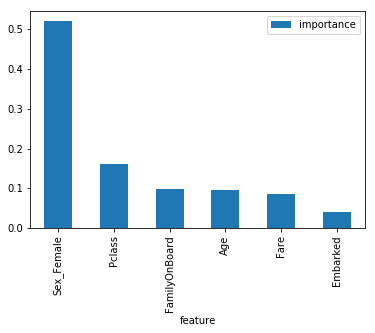

In [573]:
importances.plot.bar()

## 3 Conclusion

In [574]:
#sum up final scores
ScoreList = [ScoreLR, ScoreKNN, ScoreDT, ScoreRFC]
Methods = ['LogisticRegression', 'KNN', 'DecisionTree', 'RandomForest' ]
FinalScore = pd.DataFrame({'Methods':Methods,'Scores':ScoreList})
FinalScore.head(4)

,Methods,Scores
0,LogisticRegression,0.804469
1,KNN,0.821229
2,DecisionTree,0.832402
3,RandomForest,0.832402


#### Decision Tree Classifier and Random Forest Classification do the best forecast for this data set